In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
#import shap # for SHAP value
import random
import warnings
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from bs4 import BeautifulSoup
import re

# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm


# Use Keras Tensorflow deeplearning library

from tensorflow import set_random_seed

from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import roc_curve,auc,make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots # flor partial plots 

from scipy import interp

from itertools import cycle

from joblib import dump, load
seed_value = 123
os.environ['PYTHONHASHSEED']=str(seed_value)

Using TensorFlow backend.


In [2]:
os.getcwd()
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [3]:
# set_random_seed(123)
# random.seed(123)

In [4]:
np.random.seed(123)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline

I was messing around with the data in excel so I could filter a little bit easier. That made me think of some tweets that don't have much confidence based on the voting. 

I found that the tweets that were hate but at .444 or .5 of the proportion of votes but were still labeled in the 0 class, they actually weren't that offensive or hateful and I wanted it to learn on some better examples that weren't so ambiguous. 

It's like teaching a new student of english on the weird examples where grammar makes no sense in the language rather than the rules that work most of the time to give them an overall understanding first.

So train_no_hate.csv has a few added values for the proportion of votes so I can filter out the ones that the labeler's were less confident in as a group consensus. You could obviously easily do this with pandas, but I already made the columns in excel, so I just brought that file in. 

Just make sure if you use train.csv to change 'Column1' back to 'Unnamed: 0' in the train.drop() function

In [5]:
#train= pd.read_csv("input/train.csv")
train= pd.read_csv("train_no_hate.csv")
#test = pd.read_csv("input/test.csv")

In [6]:
# Train dataset: Need only class as "Sentiment" and text as 'Phrase'
train = train.rename(columns={'class':'Sentiment','tweet':'Phrase'})



#### WARNING, Yyou may have to change this to 'Unnamed: 0' 
#### if you are just using train.csv and not train_no_hate

train = train.drop(['Column1', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1).copy()

Here I grab a series of each of the labels and make sure the confidence rating in the vote is above 50% like I talked about earlier. Feel free to mess around with more data cleaning, I think this would do you a lot of good. 

Good data in => Good data out
Garbage in => Garbage out

In [7]:
only_offensive_df = train[train["Sentiment"] == 1]
only_offensive_df = only_offensive_df[only_offensive_df["r_off"] > 0.5]

only_hate = train[train["Sentiment"] == 0]
only_hate = only_hate[only_hate["r_hate"] > 0.5]

only = train[train["Sentiment"] == 2]
only = only[only["r_none"] > 0.5]

df = pd.DataFrame(only_offensive_df)
df = df.sample(frac=0.6) # You can adjust the % of Offensive(1) labels there are
df2 = pd.DataFrame(only)
df3 = df.append(df2)
df4 = df3.append(only_hate)
training = df4.drop(['r_hate', 'r_off', 'r_none'], axis=1).copy()
training = training.sample(frac=1) # Randomly shuffle the dataframe
training.tail()

,Sentiment,Phrase
24517,2,"the rams really dont wanna be trash, jeff fish..."
12375,2,Lets go #hoosiers #iubb &#127936; http://t.co/...
1689,0,&#8220;@alicia_688: You aint special niglet RT...
11143,1,I'd drive me crazy to have to be at that ghett...
12761,1,Marcus Colston so damn trash.


In [8]:
training.to_csv('less_ambiguous_data.csv')

In [9]:
def clean_sentences(df):
    tweets = []
    
#     for sent in tqdm(df['Phrase']):
    for sent in df['Phrase']:
        # remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", str(sent))
        
        #remove html content
        tweet_text = BeautifulSoup(tweet_text).get_text()
        
        # tokenize
        words = word_tokenize(tweet_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        tweets.append(lemma_words)
        
    return(tweets)

In [10]:
# Keras and Sklearn read arrays differently
# Create function to convert keras array to show only one highest sentiment result per list
def keras_output_sklearn(y):
    
    result = []
    
    for element in y:
        result.append(np.argmax(element))
        

    return result

In [11]:
# cleaned tweets for both train and test set retrieved

train_sentences = clean_sentences(training)

#test_sentences = clean_sentences(test)

# Splitting the Data
### Train, Validation, and Testing

So here I'm taking 80% of the labeled data and splitting it into my training and testing.

Then I'm taking that remaining 20% that is saved in X_test and y_test, I split that up 50/50 between validation and testing.

In [12]:
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target = training.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]


# Split into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_sentences,
                                                  y_target,
                                                  test_size=0.2,
                                                  random_state=seed_value,
                                                  stratify=y_target)
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                  y_test,
                                                  test_size=0.5,
                                                  random_state=seed_value,
                                                  stratify=y_test)

In [13]:
# Getting the no of unique words and max length of a tweet available in the list of cleaned tweets
# It is needed for initializing tokenizer of keras and subsequent padding

# Build an unordered collection of unique elements.
unique_words = set()
len_max = 0

# for sent in tqdm(X_train):
for sent in X_train:

    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max=len(sent)

# length of the list of unique_words gives the number of unique words

unique_words_count = len(list(unique_words))

In [14]:
# Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts_to_sequences
# ARGUMENTS: list of texts to turn to sequences
# RETURN: list of sequences (one per text input)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

In [15]:
# Padding is done to equalize the lengths of all input tweets.
# LTSM networks need all inputs to be same length.
# Therefore, tweets lesser than max length will be made equal using extra zeros at end. This is padding.
# Also, you always have to give a three-dimensional array as an input to your LSTM network



In [16]:
# Count of number of data points in each category
hate_ct = y_train.sum(axis = 0)[0]
offensive_ct = y_train.sum(axis = 0)[1]
neither_ct = y_train.sum(axis = 0)[2]
total_ct = y_train.sum()

# Calculating the inverse ratio of each category to use for the weights of the model
inv_ratio_hate = 1 - (hate_ct / total_ct)
inv_ratio_hurtful = 1 - (offensive_ct / total_ct)
inv_ratio_neither = 1 - (neither_ct / total_ct)

In [17]:
# Early stopping to prevent overfitting deep learning neural network models
# This is a method that allows you to specify an arbitrary large number of training epochs.
# This stops training once the model performance stops improving on a hold out validation dataset



# Added ModelCheckpoint, Monitor Loss, and Decay

This helps you save the best model automatically 

Monitoring Loss helps us track the information loss and let the class weights changing help us direct the scoring of our learner better. We can put the class weights very high for the underserved class we are trying to predict and low weights for the one that is over represented. This will give the initial epochs a really bad score and then have to figure out how to decend into lower and lower loss values. Especially when our model is heavily incentivized to automatically guess the offensive category, these types of tricks help.

I updated the dropout weight and that seemed to help on a lot of models. I actually gave you bad advice on dropout, it's actually the inverse of what I explained and so 0.7 means 30% of the weights get set to 0 and not 70%. 

Decay helps decrease the overfitting over time, it adjusts the weights less and less after each epoch. This will help your model learn over a longer period of time rather than having to learn everything in one pass.

This is certainly not the best version of the model. This one will be volitile because I am only taking a random 60% sample of the offensive labeled tweets, which ideally I would be able to account for but I have not been able to figure out a way.

In [39]:
early_stopper = EarlyStopping(min_delta = 0.001, mode = 'min', monitor = 'val_loss', patience = 3)
best_model_saver = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [best_model_saver, early_stopper]

# Create the model

model = Sequential()
model.add(Embedding(unique_words_count,300,input_length=len_max))
model.add(LSTM(128,dropout=0.7,recurrent_dropout=0.7,return_sequences=True))
model.add(LSTM(64,dropout=0.7,recurrent_dropout=0.7,return_sequences=False))
model.add(Dense(100,activation='relu')) #try elu
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer=Adam(lr=0.005, decay=0.005), #Adam(lr=0.001),SGD(lr=0.001)
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 53, 300)           7009500   
_________________________________________________________________
lstm_7 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 7,285,359
Trainable params: 7,285,359
Non-trainable params: 0
_________________________________________________________________


I messed with the class weights just to customize/ get more control of the loss scoring. 
I'm not sure if this is cheating but it definitely helped.

I notice that when training deep neural networks that as soon as the accuracy of the training data surpasses the accuracy of the validation data, the model really starts to overfit. So what I tried to do generally is see if I could get it to meet up at 88%, I haven't gotten it to work with the crazy weighing of classes and less offensive data, but it really helped my performance on the other models before I tried those out.

In [40]:
# fit the model adjusting for epochs, batch, and weight

model.fit(
    X_train, y_train, 
    validation_data=(X_val,y_val),
    epochs=15, #may not run all due to callback
    batch_size=256, #faster with larger batch_size but it's generalizing
    verbose=1,
    callbacks=callbacks, #stops training once the model stops improving. Prevents overfitting.
    class_weight={0: 6, #inv_ratio_hate+0.1,
                  1: 0.4, #inv_ratio_hurtful-0.1,
                  2: 0.9 }#inv_ratio_neither} #use inverse ratio to set hate with highest weight (somewhat arbitrary)
) 

Train on 13646 samples, validate on 1706 samples
Epoch 1/15
13646/13646 [==============================] - ETA: 3:26 - loss: 1.0687 - acc: 0.269 - ETA: 1:49 - loss: 0.9996 - acc: 0.232 - ETA: 1:17 - loss: 1.0597 - acc: 0.209 - ETA: 1:01 - loss: 1.0423 - acc: 0.176 - ETA: 51s - loss: 1.0640 - acc: 0.163 - ETA: 44s - loss: 1.0505 - acc: 0.14 - ETA: 39s - loss: 1.0610 - acc: 0.14 - ETA: 35s - loss: 1.0539 - acc: 0.13 - ETA: 32s - loss: 1.0661 - acc: 0.13 - ETA: 30s - loss: 1.0681 - acc: 0.13 - ETA: 28s - loss: 1.0681 - acc: 0.12 - ETA: 26s - loss: 1.0603 - acc: 0.12 - ETA: 24s - loss: 1.0561 - acc: 0.11 - ETA: 23s - loss: 1.0553 - acc: 0.11 - ETA: 22s - loss: 1.0509 - acc: 0.11 - ETA: 21s - loss: 1.0490 - acc: 0.11 - ETA: 19s - loss: 1.0446 - acc: 0.11 - ETA: 18s - loss: 1.0453 - acc: 0.11 - ETA: 17s - loss: 1.0384 - acc: 0.11 - ETA: 16s - loss: 1.0400 - acc: 0.11 - ETA: 16s - loss: 1.0390 - acc: 0.11 - ETA: 15s - loss: 1.0373 - acc: 0.11 - ETA: 14s - loss: 1.0397 - acc: 0.11 - ETA: 13s -

13646/13646 [==============================] - ETA: 16s - loss: 0.1599 - acc: 0.88 - ETA: 16s - loss: 0.1953 - acc: 0.87 - ETA: 16s - loss: 0.2001 - acc: 0.87 - ETA: 16s - loss: 0.1786 - acc: 0.88 - ETA: 16s - loss: 0.1770 - acc: 0.88 - ETA: 15s - loss: 0.1777 - acc: 0.88 - ETA: 15s - loss: 0.1785 - acc: 0.88 - ETA: 15s - loss: 0.1727 - acc: 0.89 - ETA: 14s - loss: 0.1710 - acc: 0.89 - ETA: 14s - loss: 0.1652 - acc: 0.89 - ETA: 14s - loss: 0.1654 - acc: 0.90 - ETA: 13s - loss: 0.1623 - acc: 0.90 - ETA: 13s - loss: 0.1612 - acc: 0.90 - ETA: 13s - loss: 0.1622 - acc: 0.90 - ETA: 12s - loss: 0.1682 - acc: 0.91 - ETA: 12s - loss: 0.1699 - acc: 0.91 - ETA: 12s - loss: 0.1713 - acc: 0.91 - ETA: 11s - loss: 0.1748 - acc: 0.91 - ETA: 11s - loss: 0.1767 - acc: 0.91 - ETA: 11s - loss: 0.1747 - acc: 0.91 - ETA: 10s - loss: 0.1768 - acc: 0.91 - ETA: 10s - loss: 0.1765 - acc: 0.91 - ETA: 10s - loss: 0.1729 - acc: 0.91 - ETA: 9s - loss: 0.1721 - acc: 0.9119 - ETA: 9s - loss: 0.1704 - acc: 0.912 - ET

In [41]:
# Predict validation sentiment!
y_pred = model.predict(X_test)

## How did the Model Do?

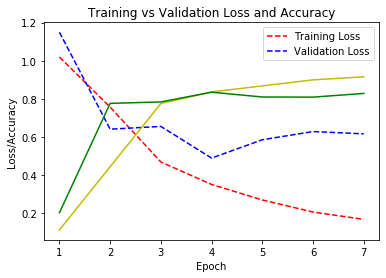

In [42]:
# Create count of the number of epochs
#model.load_weights('best_model.h5')
#model.save('../../LSTM_model.h5')
epoch_count = range(1,len(model.history.history['loss']) + 1)

# Visualize the learning curve.

plt.plot(epoch_count,model.history.history['loss'],'r--')
plt.plot(epoch_count,model.history.history['val_loss'],'b--')
plt.plot(epoch_count,model.history.history['acc'],'y-')
plt.plot(epoch_count,model.history.history['val_acc'],'g-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('Training vs Validation Loss and Accuracy')

# save figure
plt.savefig('../model_reports/loss.png')

plt.show()

In [ ]:
Do the roc curve analysis on y_test instead of y_val

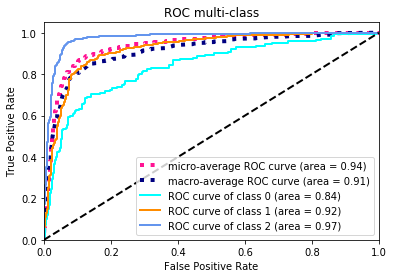

In [43]:
# Use trained Keras model to predict test inputs and generate ROC data
# Plot ROC for each of the 3 classes

# Plot linewidth.
lw = 2

# 3 classes to classify
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class')
plt.legend(loc="lower right")

# Save figure
plt.savefig('../model_reports/roc.png')

plt.show()

Do the confusion matrix on y_test rather than y_val

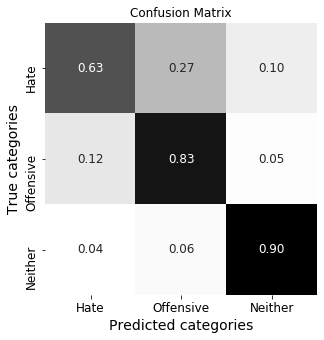

In [44]:
# Use seaborn to see counts in percentages
# Truth categories yield 100%
confusion_matrix_t = confusion_matrix(keras_output_sklearn(y_test),keras_output_sklearn(y_pred))

matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix_t[i,:]/float(confusion_matrix_t[i,:].sum())
names=['Hate','Offensive','Neither']
# save result as pandas df
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.title('Confusion Matrix')
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('../model_reports/confusion.png')

I ran this classification with y_test, but you can certainly do it with y_val and do
y_predict = model.predict(X_val) 

In [45]:
print(classification_report(keras_output_sklearn(y_test), keras_output_sklearn(y_pred)))

              precision    recall  f1-score   support

           0       0.36      0.63      0.46       142
           1       0.94      0.83      0.88      1149
           2       0.84      0.90      0.87       415

    accuracy                           0.83      1706
   macro avg       0.71      0.78      0.74      1706
weighted avg       0.87      0.83      0.84      1706



I ran a confusion matrix on the entire labeled dataset and it's in the project folder. I figured this would be a good idea since I wanted to make sure I was testing the other 40% of the offensive tweets to make sure those were labeled well and the f1 score certainly improved back to normal.